# When should you book Airbnbs in Seattle? 
A data-driven approach using Airbnb's 2016-2017 Seattle data.

Link to post: https://medium.com/when-should-you-book-airbnbs-in-seattle/when-should-you-book-airbnbs-in-seattle-7a1456a87393?sk=b6996adcdb08c62539c7d393af6ff8b6

## Introduction 
Seattle is one of Airbnb's most popular destinations in the west coast of the United States. Before booking this popular site, you might want to equip yourself with more knowledge to get the best deal. 

To help you score housing at the best prices, I used Airbnb data contaning 1393570 data points on Seattle availibilites, prices, and dates. 

Here are the three main questions we'll be exploring: 
1. *Are there more availabilities in some months relative to others?*
2. *What month is it cheapest to book in Seattle?*
3. *What day of the week do you get the best deal?*


Let's get started with some importing libraries and the data. We'll also do some data wrangling to clean the data.

In [0]:
#standard imports 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet

In [0]:
#read airbnb calendar data
df = pd.read_csv('calendar.csv')

In [0]:
#data description 
print('There are {} total data points. There are cases {} of missing data'.format(df.shape[0], df.isna().sum()[3]))
print('The ratio of missing cases is {}'.format(df.shape[0]/df.isna().sum()[3]))                                                                                                              

There are 1393570 total data points. There are cases 459028 of missing data
The ratio of missing cases is 3.035915020434483


In [0]:
print(df.head(2))
print("")
#price is object, should be float
#date should be datetime
print(df.dtypes)

   listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00

listing_id     int64
date          object
available     object
price         object
dtype: object


In [0]:
#impute missing values with mean 
df.price = df.price.str.replace("$","")
df.price = df.price.str.replace(",","")
df.price = df.price.astype(float)
df.price = df.price.fillna(df.price.mean())
df.price = pd.to_numeric(df.price)

#convert date to datetime
df.date = pd.to_datetime(df.date)

#convert available from str to float 
df.available = np.where((df.available == 't'), 1, df.available)
df.available = np.where((df.available == 'f'), 0, df.available)
df.available = pd.to_numeric(df.available)

In [0]:
df.dtypes

listing_id             int64
date          datetime64[ns]
available              int64
price                float64
dtype: object

## Part I: Are there more availabilities  in some months relative to others? 

If you're planning your trip to Seattle, you probably want to go during a month where you can have the most options to chose from. Using the Airbnb data, I discovered that: 



> There doesn't seem to be a huge differences in availabilities in most months, but you want to avoid booking in Janurary and July as the ratio of people offer accomdations is significnatly lower than average. 



In [0]:
#create copy, set index as date
df_copy = df.copy()
df_copy.index = df_copy.date

In [0]:
df_copy.head(2)

,listing_id,date,available,price
date,,,,
2016-01-04,241032,2016-01-04,1,85.0
2016-01-05,241032,2016-01-05,1,85.0


In [0]:
#group data by month 
df_copy.resample("M").mean()

,listing_id,available,price
date,,,
2016-01-31,5.550111e+06,0.554133,128.870133
2016-02-29,5.550111e+06,0.662208,128.905102
2016-03-31,5.550111e+06,0.709187,131.349153
2016-04-30,5.550111e+06,0.663847,136.054321
2016-05-31,5.550111e+06,0.675670,139.021420
2016-06-30,5.550111e+06,0.674384,144.370582
2016-07-31,5.550111e+06,0.627097,146.817843
2016-08-31,5.550111e+06,0.645051,146.144582
2016-09-30,5.550111e+06,0.674402,141.526668


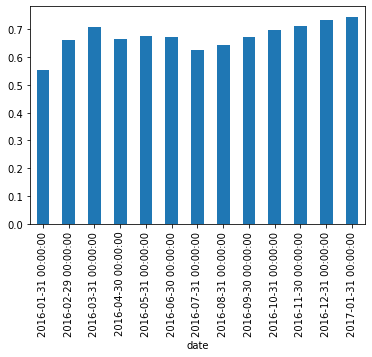

In [0]:
#plot results 
df_copy.available.resample("M").mean().plot(kind='bar')

## Part II: What month is it cheapest to book in Seattle? 

If you're planning to visit Seattle, be aware that the summer is going to be much more expensive! 

> In this section, we clearly see that June, July, and August are the most expensive months. The winter months, conversely, are much cheaper. 



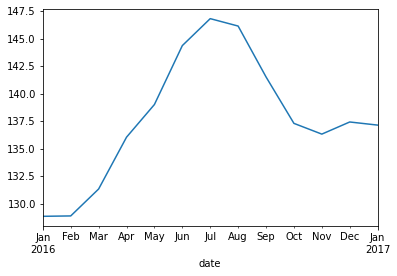

In [0]:
df_copy.price.resample("M").mean().plot()

## Part II: What day of the week do you get the best deal?

Using Facebook's Prophet model, we can get an undertanding of the time series trends for Airbnb bookings. Taking a look at the trends by week, we see that it's much more expensive to book on a weekend. 

> If you want to snag a deal, it's best to book during the weekdays. Tuesdays and Wednesdays seem particularily cheap. 

In [0]:
#labels for prophet
df_copy.rename(columns={'date':'ds', 'price':'y'}, inplace=True)
short = df_copy[:3000]

In [0]:
#fit model 
mod = Prophet()
mod.fit(short)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
#get futures
future = mod.make_future_dataframe(periods=360)
future.tail()

,ds
3355,2017-12-24
3356,2017-12-25
3357,2017-12-26
3358,2017-12-27
3359,2017-12-28


In [0]:
#predict
forecast = mod.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3355,2017-12-24,610.387524,149.868727,1039.817413
3356,2017-12-25,608.826420,188.419287,987.080743
3357,2017-12-26,608.602675,199.552566,1059.838342
3358,2017-12-27,606.945993,181.775927,1015.716182
3359,2017-12-28,608.324633,192.029148,1022.619632


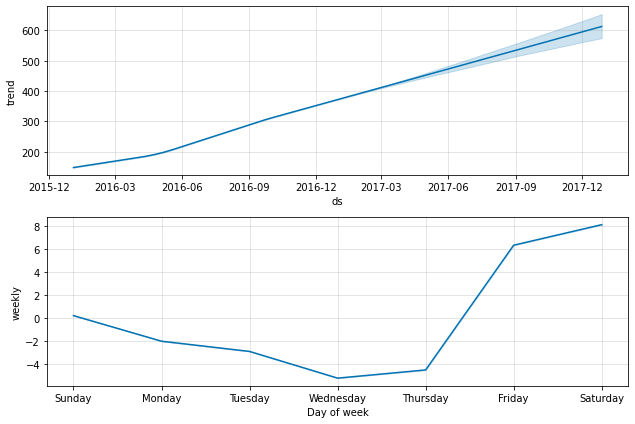

In [0]:
#plot components 
figure = mod.plot_components(forecast)

## Conclusion 

In this article, we looked at 2016/17 Seattle Airbnb data. We cleaned the data and showed that:


> 1. There are fewer availiable houses in Janurary and July.
> 2. The summer months are much more expensive to book relative to wnter months.
> 3. Booknig near the weekend is much more expensive than bookng in the middle of the week.  

We hope these tips help you with your next booking. Feel free to tell us how and when YOU like to travel.